In [47]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [48]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.layers[-1].activation = None  #keras.activations.relu



In [49]:
def kernel_grads(input_img, model_original, l_num, pred_idx=None)  :
	# First, we create a model that maps the input image to the activations
	# of the last conv layer as well as the output predictions
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		try:
			l.use_bias = True
		except:
			continue

		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				
				conv_layers.append(l)
				
				#print(l.kernel_regularizer)

	#last_conv_layer_name = conv_layers[l_num].name
	layer_num = model.layers.index(conv_layers[l_num])
	layer_num_p = model.layers.index(conv_layers[l_num-1])

	print(model.layers[layer_num].name)

	print(model.layers[layer_num-1].name)

	#second_last_conv_layer_name = conv_layers[l_num-1].name

	grad_model = keras.models.Model(
		model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
	)
	'''first_half = keras.models.Model(
		model.inputs, [model.layers[layer_num-1].output]
	)

	second_half = keras.models.Model(
		tf.keras.Input(tensor=model.layers[layer_num+1].input), [model.output]
	)

	#grad_model.get_layer(last_conv_layer_name).use_bias=False
	#grad_model.get_layer(second_last_conv_layer_name).use_bias=False
	model.layers[layer_num].activation = None'''

	with tf.GradientTape(persistent=True) as tape:
		second_last_conv_layer_output, last_conv_layer_output, preds = grad_model(input_img, training=False)

		'''activation1 =  first_half(input_img, training=False)
		act2_pre_relu = model.layers[layer_num](activation1)
		#tape.watch(act2_pre_relu)
		act2_post_relu = tf.nn.relu(act2_pre_relu)
		#tape.watch(act2_post_relu)

		preds = second_half(act2_post_relu, training=False)'''
		if pred_idx is None:
			pred_idx = tf.argmax(preds[0])
		print(tf.argmax(preds[0]))
		print(decode_predictions(preds.numpy()))
		class_channel = preds[:, pred_idx]
	print("GRAD M ", grad_model.layers[layer_num].name)
	gradsW = tape.gradient(class_channel,  grad_model.layers[layer_num].trainable_variables)[0] #

	print(model.layers[layer_num].trainable_variables[0].shape)
	grads_last = tape.gradient(class_channel,  last_conv_layer_output) #
	grads2ndlast = tape.gradient(class_channel,  second_last_conv_layer_output) #

	#print(grads)
	
	'''last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  last_conv_layer_output), axis=(0, 1, 2))
	second_last_pooled_grads = tf.reduce_mean(tape.gradient(class_channel,  second_last_conv_layer_output), axis=(0, 1, 2))'''

	#print(pooled_grads)

	#print("LAST FEATURE : ", last_conv_layer_output.shape)
	#top_k_filters = tf.math.top_k(pooled_grads, k=10).indices 
	#bottom_k_filters = tf.math.top_k(-pooled_grads, k=10).indices 
	

	return  grads2ndlast, grads_last, gradsW , second_last_conv_layer_output,last_conv_layer_output  # second_last_pooled_grads,last_pooled_grads , second_last_conv_layer_output.numpy(), last_conv_layer_output.numpy() #, bottom_k_filters, last_conv_layer_output.numpy()


In [50]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [51]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)

In [52]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img, dtype="uint8")
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [53]:
l_num  = -1

In [54]:
len(val_list)


3925

482
C:/imagenette2/train\n02979186\n02979186_2429.JPEG
block5_conv3
block5_conv2
tf.Tensor(481, shape=(), dtype=int64)
[[('n02978881', 'cassette', 19.536222), ('n02979186', 'cassette_player', 18.135675), ('n04392985', 'tape_player', 18.058035), ('n04041544', 'radio', 13.084325), ('n03494278', 'harmonica', 12.60994)]]
GRAD M  block5_conv3
(3, 3, 512, 512)


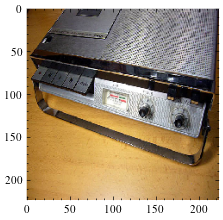

In [55]:
gc.collect()

num = 2501

original_img = get_img_array(train_list[num], size=(224,224))
img = keras.applications.vgg16.preprocess_input(original_img)

plt.imshow(original_img[0])
print(np.argmax(train_labels[num]))
print(train_list[num])

g2,g1,gw,f2,f1  = kernel_grads(img, model, l_num,  pred_idx= np.argmax(train_labels[num]))
#feature.shape
#g   #[0,:,:, 0]

In [56]:
topFilters = tf.math.top_k(tf.math.reduce_mean(g1, axis=(0,1,2)), k=5)
print(topFilters)
tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))), k=10).indices).numpy()[:, topFilters.indices.numpy()]

TopKV2(values=<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.00143668, 0.00060206, 0.00049458, 0.00048819, 0.00042425],
      dtype=float32)>, indices=<tf.Tensor: shape=(5,), dtype=int32, numpy=array([155, 337, 429,  74, 508])>)


array([[414,   5, 237, 365, 365],
       [  3, 269, 373,   5, 428],
       [269,  76, 167,  28, 269],
       [ 75,  22, 305, 288, 406],
       [406, 288, 449, 395,  95],
       [119, 315,  95, 315,  76],
       [355, 165,  49, 428, 339],
       [405, 365, 100,   2, 404],
       [ 76, 340, 494, 176,  80],
       [167, 308, 454,  75, 504]])

 ============ LAYER -1 ==================
(3, 3, 512, 512)
(512, 512)
TopKV2(values=<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.00846635, 0.00770292, 0.00504233, 0.00467667, 0.00447349,
       0.00231491, 0.00201166, 0.00171631, 0.00141486, 0.00138302],
      dtype=float32)>, indices=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([337, 508, 155,  29,  74, 112,  52, 196, 438, 395])>)


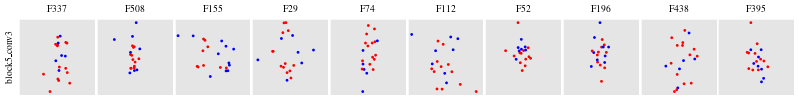

In [57]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '100'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []

fig= plt.figure(figsize = (10,13))
fig.clf()
#fig.tight_layout()
gs1 = gridspec.GridSpec(1, 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (1, 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)

#fig.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0)


#fig.set_tight_layout(True)
print(f" ============ LAYER {l_num} ==================")
#top10F= [155] #tf.math.top_k(lastGrads.numpy(), k=10).indices.numpy()  # topFilters.numpy()  #.indices#topKfilters(model, l_num, k=5)   #      #


#top10F = tf.math.top_k(tf.math.reduce_mean(g1[:,1:-2,1:-2,:], axis=(0,1,2)) * tf.where(tf.greater(tf.math.reduce_mean(f1, axis=(0,1,2)), 0), 1.,0.), k=5)



#print(topW[:, top10F.indices.numpy()])

#topChannels = tf.math.top_k(secondLastGrads.numpy(), k=5).indices.numpy()
#bottomChannels = tf.math.top_k(-secondLastGrads.numpy(), k=2).indices.numpy()
#bottomChannels = tf.math.top_k(-secondLastGrads.numpy(), k=5).indices.numpy()



filters = get_filter(model, l_num)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

mag = reduce_euclidean_norm(filters, axis=[0,1])
dc = np.sign(np.mean(filters, axis=(0,1)))
print(dc.shape)
#find lims :

top10F = tf.math.top_k(tf.math.reduce_mean(g1, axis=(0,1,2)) * tf.math.reduce_mean(f1, axis=(0,1,2)) , k=10)
print(top10F)
topW = tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))*tf.math.reduce_sum(filters**2, axis=(0,1,2))), k=20).indices).numpy()#[:, top10F.indices.numpy()]


for i,F in enumerate(top10F.indices.numpy()):  ##range(top10F.indices.numpy().shape[-1]):
	
	x =a_mag[:,F]*np.cos((theta[:,F]))
	y = a_mag[:,F]*np.sin((theta[:,F]))
	z = s_mag[:,F]*dc[:,F]
	lim_x = np.max(np.abs(x.numpy()[topW[:,F]]))
	lim_y = np.max(np.abs(y.numpy()[topW[:,F]]))
	lim_z = np.max(np.abs(z))
	lim = np.max([lim_x, lim_y])
	#lim =np.max(np.abs(mag[:, i]))    
	lim*= 1.1

	cov = np.cov([x,y])
	e_val, e_vec = np.linalg.eigh(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
	ax[0, i].set_xlim(-lim, lim)
	ax[0, i].set_ylim(-lim, lim)
	#ax[0, F].set_zlim(-lim, lim)


	

	color =  matplotlib.colors.Normalize(vmin=-1, vmax=1)(dc[topW[:,F], F])
	#alpha =  matplotlib.colors.Normalize()(dy_dw_mag.numpy()[:, top10F[i]])
	try:
		#ax[0, i].scatter(x[color>0.5],y[color>0.5],z[color>0.5], c=(dc[color>0.5, i]+1)/2, cmap="bwr",s=2)  
		#ax[0, i].scatter(x.numpy()[bottomChannels],y.numpy()[bottomChannels],z.numpy()[bottomChannels],  c='blue', cmap="Blues",s=.1)
		ax[0, i].scatter(x.numpy()[topW[:,F]],y.numpy()[topW[:,F]], c=color,s=1, cmap="bwr", vmin=0, vmax=1)
		#ax[0, F].scatter(x.numpy()[topChannels[155,:]],y.numpy()[topChannels[155,:]],z.numpy()[topChannels[155,:]], c='red',s=2)

	except Exception as e:
		print(e)
		#ax[0, i].scatter()  

	#ax[0, i].view_init(90,-90)
	ax[l_num, i].set_box_aspect(1)

	#ax[l_num, i].set_aspect('equal')
	ax[0, i].collections[0].set_rasterized(True)

	#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	'''ax[l_num, i].annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))'''


	'''ax[0, i].xaxis.pane.set_visible(False)
	ax[0, i].yaxis.pane.set_visible(False)
	ax[0, i].zaxis.pane.set_visible(False)'''
	#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")

	# Remove axis labels and ticks
	ax[0, i].set_xticks([])
	ax[0, i].set_yticks([])
	#ax[0, i].set_zticks([])
	#ax[0, i].axis('off')  # Optionally hide axis lines

	#ax[0, i].set_xlabel(f"F{F}", fontsize=7,) 
	ax[0, i].set_title(f"F{F}",  fontsize=7)  # Adjust 'pad' for spacing
	#ax[0, i].dist = 5
for i in [l_num]:
	
	ax[0, 0].set_ylabel(f"{conv_layers[i].name}", fontsize=7) 
#fig.tight_layout()

#]fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)
#fig.subplots_adjust(top=1, bottom=0, left=-1, right=1) 


In [58]:
topW = tf.transpose(tf.math.top_k(tf.transpose(tf.reduce_mean(gw, axis=(0,1))*tf.math.reduce_sum(filters**2, axis=(0,1,2))), k=20).indices).numpy()#[:, top10F.indices.numpy()]
topW[:,196]

array([ 75, 317, 272, 205, 333,   3, 414, 180,  85, 427,   7, 431, 357,
       411, 254, 386, 199, 182, 371, 447])

In [59]:
color =  matplotlib.colors.Normalize(vmin=-1, vmax=1)(-dc[topW[:,4], 4])
color

masked_array(data=[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
                   1., 1., 0., 1., 0., 1.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

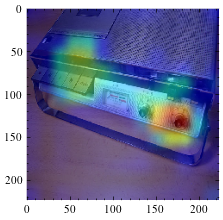

In [60]:

import matplotlib as mpl

last_conv_layer_output = f1[0]
heatmap = last_conv_layer_output @ tf.reduce_mean(g1, axis=(0, 1, 2))[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)


heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((original_img.shape[1], original_img.shape[2]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)


superimposed_img = jet_heatmap + original_img[0]
superimposed_img = keras.utils.array_to_img(superimposed_img)

plt.imshow(superimposed_img)



In [61]:
F

395

In [62]:
topW[:,F]

array([365,   5, 269, 395, 324, 308, 315, 468,  22, 288, 428, 339,  76,
       478, 165, 344, 290, 296, 340, 134])

(3, 3, 512, 512)
(20,)
Above [[317]
 [205]
 [333]
 [  3]
 [180]
 [ 85]
 [  7]]
below [[ 75]
 [272]
 [414]
 [427]]


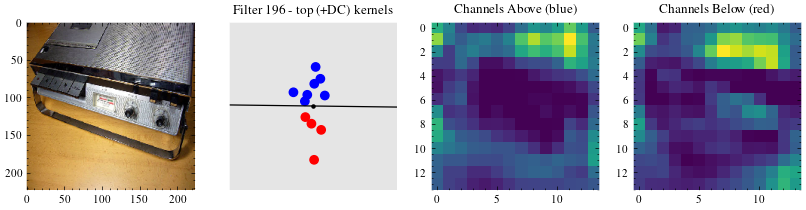

In [63]:
plt.rcParams.update({'figure.dpi': '100'})
F = 196


topW
posChannels = tf.where(tf.greater(dc[topW[:,F], F],0))[:,0].numpy()


filters = get_filter(model, l_num)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()[topW[:,F]]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()[topW[:,F]]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1



cov = np.cov([x,y])
e_val, e_vec = np.linalg.eigh(cov)
e_vec1 = e_vec[:, np.argmax(e_val)]
e_vec2 = e_vec[:, np.argmin(e_val)]

x =x[posChannels]
y = y[posChannels]
e_vec2
fig,ax  = plt.subplots(1,4,figsize=(10,3))

ax[0].imshow(original_img[0])




ax[1].scatter(x,y, c=np.sign((x * e_vec2[1]/e_vec2[0])-y), cmap = 'bwr', vmin=-1, vmax=1)
ax[1].quiver(0,0, *e_vec2, color=['black'], scale=1)
ax[1].quiver(0,0, *-e_vec2, color=['black'], scale=1)
ax[1].scatter(0,0,c='black', s=5)
ax[1].title.set_text(f"Filter {F} - top (+DC) kernels")
ax[1].set_xlim(-lim, lim)
ax[1].set_ylim(-lim, lim)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_box_aspect(1)
#### Find Channels above midline ####

channels_above = tf.where(tf.less(np.sign((x * e_vec2[1]/e_vec2[0])-y) , 0))
channels_bellow = tf.where(tf.greater(np.sign((x * e_vec2[1]/e_vec2[0])-y) , 0))

ax[2].imshow(tf.reduce_sum(f2.numpy()[:,:,:,topW[channels_above, F]], axis=(-1,-2))[0,:,:,])
ax[2].title.set_text("Channels Above (blue)")
ax[3].imshow(tf.reduce_sum(f2.numpy()[:,:,:,topW[channels_bellow, F]], axis=(-1,-2))[0,:,:,])
ax[3].title.set_text("Channels Below (red)")

print("Above", topW[channels_above, F])
print("below", topW[channels_bellow, F])



In [64]:
F

196

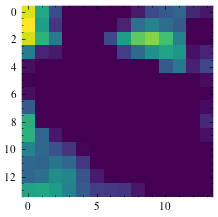

In [65]:
plt.imshow(f1[0,:,:,F])

(512, 512)
OK [-0.00896065  0.99995985] [-7.63676e-06  8.52220e-04]


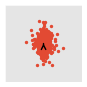

In [72]:
i=85


fig, ax = plt.subplots(1,1,figsize = (1,1))

filters = get_filter(model, -2)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
dc = np.sign(np.mean(filters, axis=(0,1)))
#idx = tf.where(tf.less(dc[:, F],0))[:,0].numpy()


s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

_, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])
print(mag.shape)

#find lims :

x =a_mag[:,i]*np.cos((theta[:,i]))
y = a_mag[:,i]*np.sin((theta[:,i]))
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
lim =np.max(np.abs(mag[:, i]))    
lim*= 1

cov = np.cov([x,y])
e_val, e_vec = np.linalg.eigh(cov)
e_vec = e_vec[:, np.argmax(e_val)]
e_val = np.max(e_val)


new_vec =  ((e_vec[0] * x + e_vec[1]*y)/(e_vec[0]**2+e_vec[1]**2))[:, None] * e_vec
new_vec = np.mean(new_vec, axis=0)

if any((np.sign(new_vec)-np.sign(e_vec))!=0) :
	print("DOWN", e_vec, new_vec)
else:
	print("OK", e_vec, new_vec)

e_vec =new_vec
#print(e_val, e_vec)

#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.scatter(x,y, s=2, color='#E24A33')
ax.set_box_aspect(1)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.collections[0].set_rasterized(True)

#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
ax.annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
			arrowprops=dict(arrowstyle="->",  color='black', lw=None))
#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
plt.show()

In [67]:
e_vec[0], e_vec[1]

(3.0042558e-05, -0.0005063679)

In [68]:
plt.scatter([:,0], (((e_vec[0] * x + e_vec[1]*y)/(e_vec[0]**2+e_vec[1]**2))[:, None] * e_vec)[:,1])
plt.quiver(0,0, *e_vec, color=['black'], scale=1)
plt.scatter(x,y)
plt.gca().set_xlim(-lim, lim)
plt.gca().set_ylim(-lim, lim)

SyntaxError: invalid syntax (631951.py, line 1)

In [ ]:
(np.sign(new_vec))


array([-1., -1.], dtype=float32)